In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Image Generation Module

Random Seed:  993


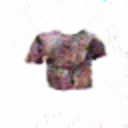

In [2]:
# Importing necessary python libraries

from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

os.chdir('/content/drive/My Drive/FY-PROJECT/implementation/Deployment')

# Set random seed for reproducibility
manualSeed = random.randint(940,1000)
# manualSeed = 996
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size =64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
#the latent space is typically a n-dimensional hypersphere with each variable drawn randomly from a Gaussian distribution with a mean of zero and a standard deviation of one.
nz = 100

# Size of feature maps in generator
ngf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


model = Generator(ngpu)
model.load_state_dict(torch.load('./Generator400.pth'))

if torch.cuda.is_available():
    model.cuda()

noise = torch.randn(128, 100, 1, 1, device=device).to(device)
generate = model(noise)

generate = generate[1]
generate.shape

# Normalization of image pixels
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

from torchvision.utils import make_grid, save_image
from PIL import Image

# fig, ax = plt.subplots(figsize=(4, 4))
# ax.set_xticks([]); ax.set_yticks([])
new_img = make_grid(denorm(generate.cpu().detach()), nrow=8)
# new_img = ax.imshow(make_grid(denorm(generate.cpu().detach()), nrow=8).permute(1, 2, 0))
new_img = transforms.ToPILImage()(new_img)
img = new_img.resize((128,128))
img.show()

img.save('./data/clip_video/frames/frames/Generated_image.jpg')
img

# Neural Style Transfer Module

In [3]:
# naive_video_pipeline.py

"""
    This script processes all of the .mp4 videos (if --specific_videos is set to None) placed in the data/ directory.

    Recommended:
    Videos should contain 1 person talking/doing something - check data/example.mp4 for a concrete (short) example.

    Processing consists out of 5 stages:
        1. Dump frames and audio file into data/clip_<video_name>
        2. Create person segmentation masks
        3. Stylize dumped frames using external NST repo (pytorch-nst-feedforward) integrated as a git submodule
        4. Combine stylized frames with masks (mask out background (1) and mask out person (2))
        5. Create videos for images (1) and (2)
"""

!pip install gitpython

import argparse
import subprocess
import time
import os
import shutil
import random
import sys
# Enables this project to see packages from pytorch-nst-feedforward submodule (e.g. utils)
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("__file__")), 'pytorch-nst-feedforward'))


import cv2 as cv


from pipeline_components.segmentation import extract_person_masks_from_frames
from pipeline_components.video_creation import create_videos
from pipeline_components.constants import *
from pipeline_components.nst_stylization import stylization
from pipeline_components.compositor import stylized_frames_mask_combiner



ptm_list = ['mosaic_4e5_e2.pth', 'starry_v3.pth', 'edtaonisl_9e5_33k.pth', 'candy.pth']
ptm_idx=  random.randrange(len(ptm_list))
ptm = ptm_list[ptm_idx]
print(f'{ptm} is the pretrained moddel currently in use...')

# pth = ptm.split('.')[0]
li = ['./data/clip_video/masks', './data/clip_video/processed_masks',  './data/clip_video/mosaic_4e5_e2',  './data/clip_video/starry_v3', 
      './data/clip_video/edtaonisl_9e5_33k',  './data/clip_video/candy']

for x in li:
  if os.path.exists(x):
    shutil.rmtree(x)
  else:
    pass

if __name__ == "__main__":
    #
    # Fixed args - don't change these unless you have a good reason
    #
    frame_extension = '.png'  # .jpg is suitable to use here - smaller size and unobservable quality loss
    mask_extension = '.png'  # don't use .jpg here! bigger size + corrupts the binary property of the mask when loaded
    frame_name_format = f'%0{FILE_NAME_NUM_DIGITS}d{frame_extension}'  # e.g. 000023.jpg
    data_path = os.path.join(os.path.dirname("__file__"), 'data')

    #
    # Modifiable args
    #
    parser = argparse.ArgumentParser()
    parser.add_argument("--specific_videos", type=str, help="Process only specific videos in data/", default=['video.mp4'])
    parser.add_argument('-f')

    

    # segmentation stage params (these 2 help with GPU VRAM problems or you can try changing the segmentation model)
    parser.add_argument("--segmentation_mask_width", type=int, help="Segmentation mask size", default=128)
    parser.add_argument("--segmentation_batch_size", type=int, help="Number of images in a batch (segmentation)", default=3)
    # 


    # stylization stage params
    parser.add_argument("--img_width", type=int, help="Stylized images width", default=128)
    parser.add_argument("--stylization_batch_size", type=int, help="Number of images in a batch (stylization)", default=3)
    parser.add_argument("--model_name", type=str, help="Model binary to use for stylization", default=ptm)

    # combine stage params
    parser.add_argument("--other_style", type=str, help="Model name without (like 'candy.pth') whose frames you want to use as an overlay", default=None)

    # video creation stage params
    parser.add_argument("--delete_source_imagery", type=bool, help="Should delete imagery after videos are created", default=False)
    args = parser.parse_args()

    # Basic error checking regarding NST submodule and model placement
    nst_submodule_path = os.path.join(os.path.dirname("__file__"), 'pytorch-nst-feedforward')
    assert os.path.exists(nst_submodule_path), 'Please pull the pytorch-nst-feedforward submodule to use this project.'
    model_path = os.path.join(nst_submodule_path, 'models', 'binaries', args.model_name)
    assert os.path.exists(model_path), f'Could not find {model_path}. Make sure to place pretrained models in there.'
    ffmpeg = 'ffmpeg'
    assert shutil.which(ffmpeg), f'{ffmpeg} not found in the system path. Please add it before running this script.'

    #
    # For every video located under data/ run this pipeline
    #
    for element in os.listdir(data_path):
        maybe_video_path = os.path.join(data_path, element)
        if os.path.isfile(maybe_video_path) and os.path.splitext(maybe_video_path)[1].lower() in SUPPORTED_VIDEO_EXTENSIONS:
            video_path = maybe_video_path
            video_name = os.path.basename(video_path).split('.')[0]

            if args.specific_videos is not None and os.path.basename(video_path) not in args.specific_videos:
                print(f'Video {os.path.basename(video_path)} not in the specified list of videos {args.specific_videos}. Skipping.')
                continue

            print('*' * 20, f'Processing video clip: {os.path.basename(video_path)}', '*' * 20)

            # Create destination directory for this video where everything related to that video will be stored
            processed_video_dir = os.path.join(data_path, 'clip_' + video_name)
            os.makedirs(processed_video_dir, exist_ok=True)

            frames_path = os.path.join(processed_video_dir, 'frames', 'frames')
            os.makedirs(frames_path, exist_ok=True)

            cap = cv.VideoCapture(video_path)
            fps = int(cap.get(cv.CAP_PROP_FPS))

            out_frame_pattern = os.path.join(frames_path, frame_name_format)
            audio_dump_path = os.path.join(processed_video_dir, video_name + '.aac')

            #
            # step1: Extract frames from the videos as well as audio file
            #
            if len(os.listdir(frames_path)) == 0:
                subprocess.call([ffmpeg, '-i', video_path, '-r', str(fps), '-start_number', '0', '-qscale:v', '2', out_frame_pattern, '-c:a', 'copy', audio_dump_path])
            else:
                print('Skip splitting video into frames and audio, already done.')
            print('Stage 1/5 done (split video into frames and audio file).')

            #
            # step2: Extract person segmentation mask from frames
            #
            ts = time.time()
            mask_dirs = extract_person_masks_from_frames(processed_video_dir, frames_path, args.segmentation_batch_size, args.segmentation_mask_width, mask_extension)
            print('Stage 2/5 done (create person segmentation masks).')
            print(f'Time elapsed computing masks: {(time.time() - ts):.3f} [s].')

            #
            # step3: Stylize dumped video frames
            #
            ts = time.time()
            style_dir = stylization(frames_path, args.model_name, args.img_width, args.stylization_batch_size)
            print('Stage 3/5 done (stylize dumped video frames).')
            print(f'Time elapsed stylizing imagery: {(time.time() - ts):.3f} [s].')

            #
            # step4: Combine stylized frames with masks
            #
            relevant_directories = {'frames_path': frames_path, 'audio_path': audio_dump_path}
            relevant_directories.update(mask_dirs)
            relevant_directories.update(style_dir)

            ts = time.time()
            if args.other_style is not None:
                args.other_style = args.other_style.split('.')[0] if args.other_style.endswith('.pth') else args.other_style
                other_style = os.path.join(processed_video_dir, args.other_style, 'stylized')
                assert os.path.exists(other_style) and os.path.isdir(other_style), f'You first need to create stylized frames for the model {args.other_style}.pth so that you can use it as the other style for this model {args.model_name}.'
            else:
                other_style = None

            combined_dirs = stylized_frames_mask_combiner(relevant_directories, frame_extension, other_style)
            print('Stage 4/5 done (combine masks with stylized frames).')
            print(f'Time elapsed masking stylized imagery: {(time.time() - ts):.3f} [s].')

            #
            # step5: Create videos
            #
            relevant_directories.update(combined_dirs)

            video_metadata = {'fps': fps}
            create_videos(video_metadata, relevant_directories, frame_name_format, args.delete_source_imagery)
            print('Stage 5/5 done (create videos from overlayed stylized frames).')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 33.4 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
mosaic_4e5_e2.pth is the pretrained moddel currently in use...
******************** Processing video clip: video.mp4 ********************
Skip splitting video into frames and audio, already done.
Stage 1/5 done (split video into frames and audio file).


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Number of trainable weights in the segmentation model: 60996202
******************** Person segmentation stage started ********************
Processing batch 1 (1/1 processed images).
Stage 2/5 done (create person segmentation masks).
Time elapsed computing masks: 2.530 [s].
******************** Frame stylization stage started ********************
Stage 3/5 done (stylize dumped video frames).
Time elapsed stylizing imagery: 8.384 [s].
Stage 4/5 done (combine masks with stylized frames).
Time elapsed masking stylized imagery: 0.024 [s].
Stage 5/5 done (create videos from overlayed stylized frames).


In [5]:
pip freeze> requirements.txt